In [254]:
from collections import Counter
import numpy as np
import pandas as pd
import Levenshtein  # pip install python-Levenshtein
import re
from collections import Counter
import Levenshtein
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import scipy.stats as stats



In [255]:
# Show all columns
pd.set_option('display.max_columns', None)

# Show all rows
pd.set_option('display.max_rows', None)

# Prevent truncating column content
pd.set_option('display.max_colwidth', None)  # For pandas < 1.0 use -1 instead of None


In [256]:
data = pd.read_csv('df_f_1.csv')

In [257]:
data.head(10)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT
0,7/31/2019,1x Dual Sim,Alcatel 1x Dual Sim,alcatel,Google,Android,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,nan,Non-Saudi,4
1,3/31/2019,K7 Dual Sim,LG K7 Dual Sim,NaN,Google,Android,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1
2,11/30/2019,ELUGA I3,Panasonic ELUGA I3,Panasonic,Google,Androxd,Smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1
3,8/31/2019,M98,HEDY M98,hedy,HEDY,Proprietary,Mobile Phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3
4,12/31/2019,|105,NaN,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,NaN,N,Male,NA,IND,India,Non-Saudi,3758
5,1/31/2020,One Touch 1050 Dual Sim,Alcatel One Touch 1050 Dual Sim,ALCATEL,Alcatel,Proprietary,Mobile Phone,Y,N,N,N,N,N,Y,Male,36-55,BHR,Bahrain,Non-Saudi,1
6,NaN,Moto M# Dual Sim,Motorola Moto M Dual Sim,MOTOROLA,Google,Androiy,Smartphone,Y,Y,Y,Y,Y,Y,Y,Female,>55,SYR,Syria,Non-Saudi,1
7,2/29/2020,K802,Kaliho K802,kaliho,Google,Android,Smartphone,Y,Y,N,NaN,Y,Y,Y,Male,18-25,IDN,Indonesia,Non-Saudi,1
8,1/31/2019,T528,Tecno T528,tecno,Tecno Technology,NaN,Mobile Phone,Y,N,N,N,NaN,N,Y,Male,NaN,NGA,Nigerian,Non-Saudi,14
9,12/31/2019,2310,Nokia 2310,NOKIA,Nokia,Proprietary,Mobile Phone,Y,N,N,N,N,N,N,Female,36-55,PHL,Philippines,Non-Saudi,5


In [258]:
df=data.copy()

# Remove Special characters

In [259]:
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Standardize the flag values
for col in flag_cols:
    df[col] = df[col].astype(str).str.strip().str.lower().map({
        'yes': 'y', 'no': 'n',
        'Y': 'y', 'N': 'n'
    }).fillna(df[col])


In [260]:
df['DEVICE_COUNT'] = df['DEVICE_COUNT'].replace('ten', 10)


In [261]:
df = df.applymap(lambda x: re.sub(r'\s+', ' ', str(x).strip()) if isinstance(x, str) else x)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\2478850691.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: re.sub(r'\s+', ' ', str(x).strip()) if isinstance(x, str) else x)


In [262]:
cols_to_lower = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_lower:
    df[col] = df[col].apply(lambda x: x.lower() if isinstance(x, str) else x)


In [263]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\490592483.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [264]:
cols_to_clean = ['MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']

for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' | ', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace(' |', '', regex=False)


for col in cols_to_clean:
    df[col] = df[col].astype(str).str.replace('|', '', regex=False)


# Step 1: Remove unwanted characters (except parentheses)
symbol_pattern = r"[!@#$%^&*_=\{\};:'\"<>,.?/\\|`~\[\]]"  # Adjusted to include more symbols

# Step 2: Remove unmatched ( or )
def remove_unmatched_parens(text):
    if not isinstance(text, str):
        return text

    # Count opening and closing
    open_count = text.count('(')
    close_count = text.count(')')

    # If unmatched '(', remove it
    if open_count > close_count:
        text = text.replace('(', '')
    # If unmatched ')', remove it
    if close_count > open_count:
        text = text.replace(')', '')

    return text

# Apply both cleaning steps
for col in cols_to_clean:
    df[col] = df[col].apply(lambda x: re.sub(symbol_pattern, '', x) if isinstance(x, str) else x)
    df[col] = df[col].apply(remove_unmatched_parens)


In [265]:
# Cleaning function: remove '+' only if not at the end
def clean_plus(text):
    if isinstance(text, str):
        return re.sub(r'\+(?=\w)', '', text)
    return text

# Apply the function to each column
for col in cols_to_lower:
    df[col] = df[col].apply(clean_plus)

In [266]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


# Correct Names and misspelling

In [267]:
# This function corrects similar values in a specified column of a DataFrame
# using Levenshtein distance to group similar strings and replace them with the most frequent value

def correct_similar_values(df, column, max_distance=2):
    print(f"Cleaning column: '{column}'")

    # Step 1: Drop NaNs and prepare the value list
    values = df[column].dropna().astype(str).str.strip()
    frequencies = Counter(values)
    unique_values = list(frequencies.keys())
    visited = set()
    corrections = {}

    # Step 2: Compare all pairs to find similar groups
    for i, val1 in enumerate(unique_values):
        if val1 in visited:
            continue
        group = [val1]
        for val2 in unique_values[i+1:]:
            if val2 in visited:
                continue
            if Levenshtein.distance(val1.lower(), val2.lower()) <= max_distance:
                group.append(val2)
                visited.add(val2)
        visited.add(val1)

        # Pick the most frequent value in the group
        if len(group) > 1:
            canonical = max(group, key=lambda x: frequencies[x])
            for val in group:
                if val != canonical:
                    corrections[val] = canonical

    # Step 3: Apply corrections
    df_cleaned = df.copy()
    df_cleaned[column] = df_cleaned[column].apply(lambda x: corrections.get(x, x) if isinstance(x, str) else x)

    print(f"Unique values reduced: {df[column].nunique()} → {df_cleaned[column].nunique()}")
    return df_cleaned, corrections

In [268]:
columns_to_fix = ['NATIONALITY_NAME', 'SAUDI_NON_SAUDI', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'BRAND_NAME']

for col in columns_to_fix:
    df, fixes = correct_similar_values(df, column=col)

Cleaning column: 'NATIONALITY_NAME'
Unique values reduced: 1595 → 206
Cleaning column: 'SAUDI_NON_SAUDI'
Unique values reduced: 2 → 2
Cleaning column: 'VENDOR_NAME'
Unique values reduced: 845 → 107
Cleaning column: 'OS_NAME'
Unique values reduced: 201 → 9
Cleaning column: 'DEVICE_TYPE'
Unique values reduced: 2 → 2
Cleaning column: 'BRAND_NAME'
Unique values reduced: 1171 → 170


In [269]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
uyknown               37
windows mobile        34
Name: count, dtype: int64

In [270]:
# Fix the logic to correctly replace 'uyknown' with 'unknown' in OS_NAME
df.loc[df['OS_NAME'] == 'uyknown', 'OS_NAME'] = 'unknown'

In [271]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
unknown               37
windows mobile        34
Name: count, dtype: int64

In [272]:
# Replace values that are: nan/NA/unknown (case-insensitive) or only whitespace
df = df.applymap(
    lambda x: np.nan if isinstance(x, str) and x.strip().lower() in ['nan', 'na', 'unknown', ''] else x
)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\1795654457.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(


In [273]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               59911
htc                 13683
lenovo              12380
lg                  10697
sony                 9811
xiaomi               9779
alcatel              8860
oppo                 5991
vivo                 4897
lava                 4796
tecno                4592
motorola             4473
panasonic            4078
oneplus              2863
four                 2730
infinix              2662
rim                  1952
mione                1748
asus                 1628
symphony             1591
philips              1547
blackberry           1517
microsoft            1077
bocoin                975
micromax              972
innjoo                971
darago                720
google                629
sony ericsson         610
star                  551
qmobile               526
eurostar  device      511
obi                   419
realme                411
xtouch                397
iku                   350
hope                  331
fero                  324
e

In [274]:
# Define the corrections
brand_corrections = {
    'cecz': 'cect',
    'hzc': 'htc',
    'ityl': 'itzl',
    'miyne': 'mione',
    'mphzne': 'mphone',
    'sict': 'sico',
    'wyko': 'wiko',
    'xltzl': 'xltel'
}

# Apply corrections to the 'BRAND_NAME' column
df['BRAND_NAME'] = df['BRAND_NAME'].replace(brand_corrections)


In [275]:
df['VENDOR_NAME'] = df['VENDOR_NAME'].replace(r'(?i)^goo$', 'google', regex=True)

# Outliers

In [276]:
df.DEVICE_COUNT.head().value_counts()

DEVICE_COUNT
1       2
4       1
3       1
3758    1
Name: count, dtype: int64

In [277]:
data['DEVICE_COUNT'].isna().sum()

np.int64(12052)

In [278]:
#Because there was 'ten' string
df['DEVICE_COUNT'] = pd.to_numeric(df['DEVICE_COUNT'], errors='coerce').astype('Int64')

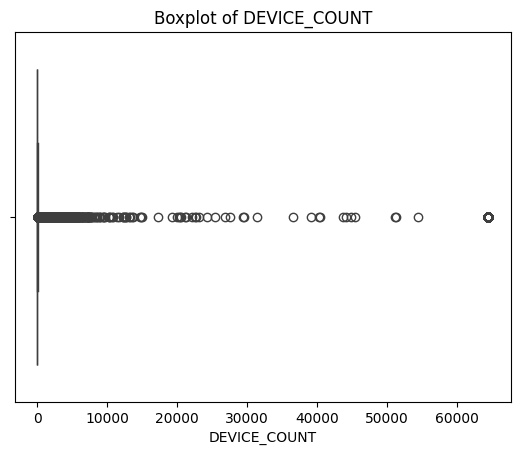

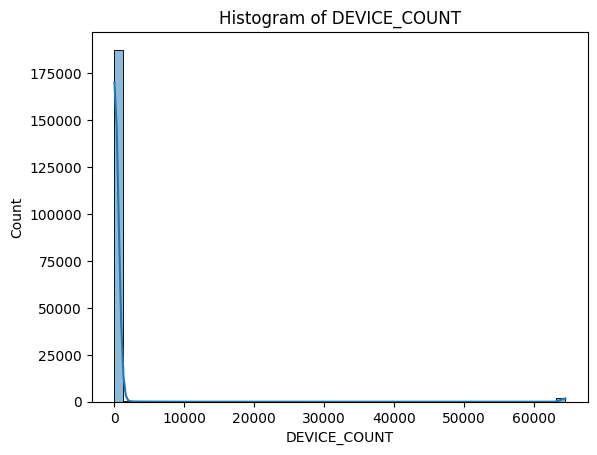

In [279]:
sns.boxplot(x=df['DEVICE_COUNT'])
plt.title("Boxplot of DEVICE_COUNT")
plt.show()

sns.histplot(df['DEVICE_COUNT'], bins=50, kde=True)
plt.title("Histogram of DEVICE_COUNT")
plt.show()


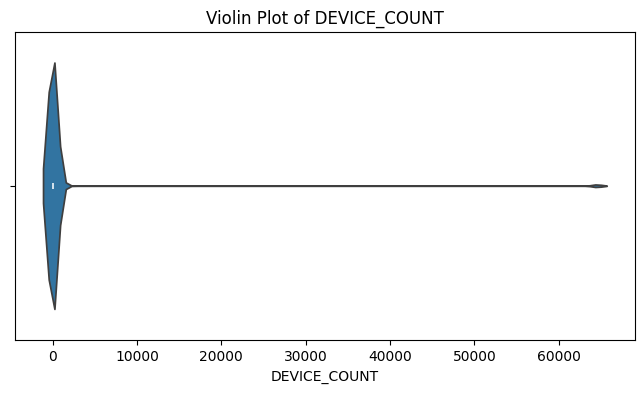

In [280]:
plt.figure(figsize=(8, 4))
sns.violinplot(x=df['DEVICE_COUNT'])
plt.title("Violin Plot of DEVICE_COUNT")
plt.xlabel("DEVICE_COUNT")
plt.show()

In [281]:
Q1 = df['DEVICE_COUNT'].quantile(0.25)
Q3 = df['DEVICE_COUNT'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['DEVICE_COUNT'] < lower_bound) | (df['DEVICE_COUNT'] > upper_bound)]
print(f"Outliers found: {len(outliers)}")


Outliers found: 28285


In [282]:
df.OS_NAME.value_counts()

OS_NAME
android           108906
proprietary        64263
symbian             6445
other               4618
rim os              1986
windows phone       1815
blackberry os        962
windows mobile        34
Name: count, dtype: int64

In [283]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [284]:
df.BRAND_NAME.value_counts()

BRAND_NAME
nokia               59911
htc                 13877
lenovo              12380
lg                  10697
sony                 9811
xiaomi               9779
alcatel              8860
oppo                 5991
vivo                 4897
lava                 4796
tecno                4592
motorola             4473
panasonic            4078
oneplus              2863
four                 2730
infinix              2662
rim                  1952
mione                1784
asus                 1628
symphony             1591
philips              1547
blackberry           1517
microsoft            1077
bocoin                975
micromax              972
innjoo                971
darago                720
google                629
sony ericsson         610
star                  551
qmobile               526
eurostar  device      511
obi                   419
realme                411
xtouch                397
iku                   350
hope                  331
fero                  324
e

In [285]:
from sklearn.preprocessing import RobustScaler

def replace_outliers_with_scaled_safe(data, outlier_method='iqr'):
    """
    Apply RobustScaler with data cleaning and outlier replacement
    """
    # Clean data first
    clean_data = pd.to_numeric(data, errors='coerce')
    
    # Remove NaN values for processing
    valid_mask = clean_data.notna()
    valid_data = clean_data[valid_mask]
    
    if len(valid_data) == 0:
        return data.copy(), pd.Series(False, index=data.index)
    
    # Step 1: Identify outliers
    if outlier_method == 'iqr':
        Q1 = valid_data.quantile(0.25)
        Q3 = valid_data.quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_mask = (valid_data < lower_bound) | (valid_data > upper_bound)
    
    elif outlier_method == 'zscore':
        z_scores = np.abs((valid_data - valid_data.mean()) / valid_data.std())
        outlier_mask = z_scores > 3
    
    # Step 2: Apply RobustScaler to valid data
    scaler = RobustScaler()
    scaled_data = scaler.fit_transform(valid_data.values.reshape(-1, 1)).flatten()
    
    # Step 3: Create result
    result = clean_data.copy()
    result[valid_mask] = valid_data  # Keep original non-outliers
    result = result.astype(float)  # Add this before assignment
    result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers
    
    return result, outlier_mask

# Usage
df['DEVICE_COUNT_processed'], outliers_mask = replace_outliers_with_scaled_safe(df['DEVICE_COUNT'])

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\2363318935.py:38: FutureWarning: Operation between non boolean Series with different indexes will no longer return a boolean result in a future version. Cast both Series to object type to maintain the prior behavior.
  result[valid_mask & outlier_mask] = scaled_data[outlier_mask]  # Replace outliers


In [286]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202000 entries, 0 to 201999
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CAL_DT                  189965 non-null  object 
 1   MODEL_NAME              189955 non-null  object 
 2   BRAND_FULL_NAME         189949 non-null  object 
 3   BRAND_NAME              189952 non-null  object 
 4   VENDOR_NAME             189067 non-null  object 
 5   OS_NAME                 189029 non-null  object 
 6   DEVICE_TYPE             189909 non-null  object 
 7   _2G_FLG                 189935 non-null  object 
 8   _3G_FLG                 189939 non-null  object 
 9   _4G_FLG                 189927 non-null  object 
 10  WIFI_FLG                189946 non-null  object 
 11  BLUETOOTH_FLG           189968 non-null  object 
 12  TOUCH_SCREEN_FLG        189945 non-null  object 
 13  DUAL_SIM_FLG            189955 non-null  object 
 14  GENDER_TYPE_CD      

In [287]:
# Now this should work
print("Outliers before and after:")
threshold = df['DEVICE_COUNT_processed'].quantile(0.95)
outliers_mask = (df['DEVICE_COUNT_processed'] > threshold)

comparison = pd.DataFrame({
    'Original': df['DEVICE_COUNT'].head(10),
    'Processed': df['DEVICE_COUNT_processed'].head(10)
})
print(comparison)

Outliers before and after:
   Original  Processed
0         4        4.0
1         1        1.0
2         1        1.0
3         3        3.0
4      3758      626.0
5         1        1.0
6         1        1.0
7         1        1.0
8        14       14.0
9         5        5.0


# Fill null

In [288]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,7/31/2019,1x dual sim,alcatel 1x dual sim,alcatel,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Female,26-35,NaN,NaN,Non-Saudi,4,4.0
1,3/31/2019,k7 dual sim,lg k7 dual sim,NaN,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,18-25,JOR,Jordan,Non-Saudi,1,1.0
2,11/30/2019,eluga i3,panasonic eluga i3,panasonic,google,android,smartphone,Y,Y,N,Y,Y,Y,Y,Female,>55,ZAF,South Africa,Non-Saudi,1,1.0
3,8/31/2019,m98,hedy m98,hedy,hedy,proprietary,mobile phone,Y,N,N,N,NaN,N,N,Female,36-55,YEM,Yemen,Non-Saudi,3,3.0
4,12/31/2019,105,NaN,nokia,nokia,proprietary,mobile phone,Y,N,N,N,N,NaN,N,Male,NaN,IND,India,Non-Saudi,3758,626.0


In [289]:
df.isna().sum()

CAL_DT                    12035
MODEL_NAME                12045
BRAND_FULL_NAME           12051
BRAND_NAME                12048
VENDOR_NAME               12933
OS_NAME                   12971
DEVICE_TYPE               12091
_2G_FLG                   12065
_3G_FLG                   12061
_4G_FLG                   12073
WIFI_FLG                  12054
BLUETOOTH_FLG             12032
TOUCH_SCREEN_FLG          12055
DUAL_SIM_FLG              12045
GENDER_TYPE_CD            34642
AGE_B                     41312
NATIONALITY_CD            31503
NATIONALITY_NAME          31440
SAUDI_NON_SAUDI           12053
DEVICE_COUNT              12052
DEVICE_COUNT_processed    12052
dtype: int64

In [290]:
df.DEVICE_TYPE.value_counts()

DEVICE_TYPE
smartphone      121340
mobile phone     68569
Name: count, dtype: int64

In [291]:
# Clean NATIONALITY_CD
df['NATIONALITY_CD'] = df['NATIONALITY_CD'].apply(
    lambda x: x.strip().upper() if isinstance(x, str) else x
)

# Clean NATIONALITY_NAME
df['NATIONALITY_NAME'] = df['NATIONALITY_NAME'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)

# Clean SAUDI_NON_SAUDI
df['SAUDI_NON_SAUDI'] = df['SAUDI_NON_SAUDI'].apply(
    lambda x: x.strip().title() if isinstance(x, str) else x
)


In [292]:
df['SAUDI_NON_SAUDI'] = np.where(
    (df['NATIONALITY_CD'] == 'SAU') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'Saudi',
    df['SAUDI_NON_SAUDI']
)

In [293]:
df['NATIONALITY_CD'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_NAME'] == 'Saudi Arabia'),
    'SAU',
    df['NATIONALITY_CD']
)


In [294]:
df['NATIONALITY_NAME'] = np.where(
    (df['SAUDI_NON_SAUDI'] == 'Saudi') | (df['NATIONALITY_CD'] == 'SAU'),
    'Saudi Arabia',
    df['NATIONALITY_NAME']
)


In [295]:
df.columns

Index(['CAL_DT', 'MODEL_NAME', 'BRAND_FULL_NAME', 'BRAND_NAME', 'VENDOR_NAME',
       'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
       'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG', 'GENDER_TYPE_CD',
       'AGE_B', 'NATIONALITY_CD', 'NATIONALITY_NAME', 'SAUDI_NON_SAUDI',
       'DEVICE_COUNT', 'DEVICE_COUNT_processed'],
      dtype='object')

Fix CutOff and mispelling of Model Name

In [296]:
# 1. Make sure model_name and BRAND_NAME are strings
df['MODEL_NAME'] = df['MODEL_NAME'].astype(str).replace('nan', np.nan)
df['BRAND_NAME'] = df['BRAND_NAME'].astype(str).replace('nan', np.nan)
df['BRAND_FULL_NAME'] = df['BRAND_FULL_NAME'].astype(str).replace('nan', np.nan)

# 2. Create unique list of brand names
unique_brands = df['BRAND_NAME'].dropna().unique().tolist()

# 3. Helper function to extract model from BRAND_FULL_NAME
def extract_model(row):
    brand = row['BRAND_NAME']
    full = row['BRAND_FULL_NAME']
    model = row['MODEL_NAME']
    
    # CASE 1: MODEL_NAME is NOT null
    if pd.notnull(model) and pd.notnull(full):
        # remove BRAND_NAME from BRAND_FULL_NAME
        for b in unique_brands:
            if full.startswith(b + ' '):
                expected_model = full[len(b):].strip()
                if model.strip() != expected_model:
                    return expected_model  # fix incorrect model
                return model.strip()
        return model.strip()
    
    # CASE 2: MODEL_NAME is null but BRAND_FULL_NAME exists
    if pd.isnull(model) and pd.notnull(full):
        for b in unique_brands:
            if full.startswith(b + ' '):
                return full[len(b):].strip()
        return full.strip()  # fallback if brand not matched
    
    return np.nan  # model still unknown

# Apply the function to fix MODEL_NAME
df['MODEL_NAME_fixed'] = df.apply(extract_model, axis=1)

# Group columns for filling remaining nulls
group_cols = [
    'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', '_2G_FLG', '_3G_FLG',
    '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG',
    'DUAL_SIM_FLG', 'GENDER_TYPE_CD'
]

# Function to get mode value per group
def fill_model_mode(group):
    mode_val = group['MODEL_NAME_fixed'].mode()
    if not mode_val.empty:
        group['MODEL_NAME_fixed'] = group['MODEL_NAME_fixed'].fillna(mode_val.iloc[0])
    return group

# Apply group-wise mode filling
df = df.groupby(group_cols, dropna=False).apply(fill_model_mode).reset_index(drop=True)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\1419724558.py:53: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(group_cols, dropna=False).apply(fill_model_mode).reset_index(drop=True)


In [297]:
df['MODEL_NAME'] = df['MODEL_NAME_fixed']
df.drop(columns=['MODEL_NAME_fixed'], inplace=True)

In [298]:
# Function to infer BRAND_NAME from BRAND_FULL_NAME
def fill_brand_from_full(row):
    brand = row['BRAND_NAME']
    full = row['BRAND_FULL_NAME']
    
    if pd.isnull(brand) and pd.notnull(full):
        for b in unique_brands:
            if full.startswith(b + ' ') or full == b:
                return b
    return brand

# Apply function to fill missing BRAND_NAME
df['BRAND_NAME'] = df.apply(fill_brand_from_full, axis=1)

In [299]:
# Fill brand_full_name when null by combining brand_name and model_name
df['BRAND_FULL_NAME'] = df.apply(
    lambda row: f"{row['BRAND_NAME']} {row['MODEL_NAME']}".strip() 
    if pd.isnull(row['BRAND_FULL_NAME']) and pd.notnull(row['BRAND_NAME']) and pd.notnull(row['MODEL_NAME']) 
    else row['BRAND_FULL_NAME'], axis=1
)

In [300]:
# Define a function to fill nulls with the group's most common DEVICE_TYPE
def fill_device_type(group):
    if group['DEVICE_TYPE'].isnull().any():
        mode = group['DEVICE_TYPE'].mode()
        if not mode.empty:
            group['DEVICE_TYPE'] = group['DEVICE_TYPE'].fillna(mode.iloc[0])
    return group

# Apply the function on each group
df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\3383298152.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(['OS_NAME', 'VENDOR_NAME'], group_keys=False).apply(fill_device_type)


In [301]:
# Make a copy to avoid modifying original
df_clean = df.copy()

# Step 1: Fill using group-based mode
def fill_vendor_by_group(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\4005558391.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby(['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE'], group_keys=False).apply(fill_vendor_by_group)


In [302]:
# Step 2: Fill remaining nulls by BRAND_NAME only
def fill_vendor_by_brand(group):
    if group['VENDOR_NAME'].isnull().any():
        mode = group['VENDOR_NAME'].mode()
        if not mode.empty:
            group['VENDOR_NAME'] = group['VENDOR_NAME'].fillna(mode.iloc[0])
    return group

df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\3384394963.py:9: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_clean = df_clean.groupby('BRAND_NAME', group_keys=False).apply(fill_vendor_by_brand)


In [303]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import KNNImputer

# Step 3: Fill remaining with KNNImputer
# Select only relevant columns (encode all as numeric)
cols_for_knn = ['BRAND_NAME', 'OS_NAME', 'DEVICE_TYPE', 'VENDOR_NAME']
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
encoded_data = encoder.fit_transform(df_clean[cols_for_knn])

# KNN imputation
imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(encoded_data)

# Restore back only the imputed vendor_name (last column)
df_clean['VENDOR_NAME'] = encoder.inverse_transform(imputed_data)[:, -1]


In [304]:
df.VENDOR_NAME = df_clean.VENDOR_NAME.copy()

In [305]:
df.isna().sum()

CAL_DT                    10628
MODEL_NAME                  454
BRAND_FULL_NAME            1060
BRAND_NAME                  890
VENDOR_NAME                 891
OS_NAME                       0
DEVICE_TYPE                   1
_2G_FLG                   10609
_3G_FLG                   10606
_4G_FLG                   10688
WIFI_FLG                  10579
BLUETOOTH_FLG             10601
TOUCH_SCREEN_FLG          10607
DUAL_SIM_FLG              10605
GENDER_TYPE_CD            30471
AGE_B                     36340
NATIONALITY_CD            19454
NATIONALITY_NAME          19435
SAUDI_NON_SAUDI           10000
DEVICE_COUNT              10596
DEVICE_COUNT_processed    10596
dtype: int64

In [306]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))    
    rcorr = r - ((r - 1)**2)/(n - 1)
    kcorr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

# Example:
cramers_v(df['AGE_B'], df['DEVICE_TYPE'])


np.float64(0.0628104623993839)

In [307]:
nat_map = {}

for _, row in df.iterrows():
    cd = row['NATIONALITY_CD']
    name = row['NATIONALITY_NAME']
    
    if pd.notna(cd) and pd.notna(name):
        if cd not in nat_map:
            nat_map[cd] = name


In [308]:
nat_map

{'IDN': 'Indonesia',
 'LKA': 'Sri Lanka',
 'PHL': 'Philippines',
 'SAU': 'Saudi Arabia',
 'JOR': 'Jordan',
 'ZAF': 'South Africa',
 'NGA': 'Nigerian',
 'DZA': 'Algeria',
 'EGY': 'Egypt',
 'ETH': 'Ethiopia',
 'MAR': 'Morocco',
 'SDN': 'Sudan',
 'BGD': 'Bangladesh',
 'UZB': 'Uzbekistan',
 'PAK': 'Pakistan',
 'IND': 'India',
 'SYR': 'Syria',
 'NPL': 'Nepal',
 'MLI': 'Mali',
 'ERI': 'Eritrea',
 'LBN': 'Lebanon',
 'YEM': 'Yemen',
 'AFG': 'Afghanistan',
 'IRL': 'Ireland',
 'TUN': 'Tunisia',
 'IRQ': 'Iraq',
 'NER': 'Niger',
 'BRN': 'Brunei',
 'PSE': 'Palestine',
 'SEN': 'Senegal',
 'GBR': 'United Kingdom',
 'MYS': 'Malaysia',
 'TCD': 'Chad',
 'KAZ': 'Kazakhstan',
 'SOM': 'Somalia',
 'KWT': 'Kuwait',
 'BDI': 'Brunei',
 'BFA': 'Burkina Faso',
 'KGZ': 'Kyrgyzstan',
 'ALB': 'Albania',
 'GHA': 'Ghana',
 'BHR': 'Bahrain',
 'TUR': 'Turkey',
 'KEN': 'Kenya',
 'AND': 'Andorra',
 'AUS': 'Australia',
 'THA': 'Thailand',
 'AUT': 'Australia',
 'COL': 'Colombia',
 'IRN': 'Iraq',
 'MRT': 'Mauritania',
 'ITA

In [309]:
df[df['NATIONALITY_CD'] == 'MAR'].head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
15,8/31/2019,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,36-55,MAR,Morocco,Non-Saudi,1,1.0
272,12/31/2019,one touch 1035 dual sim,alcatel one touch 1035 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Female,>55,MAR,NaN,Non-Saudi,1,1.0
352,4/30/2020,1066 dual sim,alcatel 1066 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Male,NaN,MAR,Morocco,Non-Saudi,1,1.0
396,6/30/2019,one touch 1016 dual sim,alcatel one touch 1016 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Male,36-55,MAR,Morocco,NaN,1,1.0
435,2/28/2019,one touch 1016 dual sim,alcatel one touch 1016 dual sim,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,Y,Male,26-35,MAR,Morocco,Non-Saudi,1,1.0


In [310]:
# Step 2: Build reverse dictionary (to fill CD from name)
rev_nat_map = {v: k for k, v in nat_map.items()}

# Step 3: Fill missing values
def fill_nationality(row):
    if pd.isna(row['NATIONALITY_NAME']) and pd.notna(row['NATIONALITY_CD']):
        row['NATIONALITY_NAME'] = nat_map.get(row['NATIONALITY_CD'])
    elif pd.isna(row['NATIONALITY_CD']) and pd.notna(row['NATIONALITY_NAME']):
        row['NATIONALITY_CD'] = rev_nat_map.get(row['NATIONALITY_NAME'])
    return row

# Step 4: Apply row-wise
df = df.apply(fill_nationality, axis=1)


In [311]:
df.isna().sum()

CAL_DT                    10628
MODEL_NAME                  454
BRAND_FULL_NAME            1060
BRAND_NAME                  890
VENDOR_NAME                 891
OS_NAME                       0
DEVICE_TYPE                   1
_2G_FLG                   10609
_3G_FLG                   10606
_4G_FLG                   10688
WIFI_FLG                  10579
BLUETOOTH_FLG             10601
TOUCH_SCREEN_FLG          10607
DUAL_SIM_FLG              10605
GENDER_TYPE_CD            30471
AGE_B                     36340
NATIONALITY_CD            11129
NATIONALITY_NAME          11099
SAUDI_NON_SAUDI           10000
DEVICE_COUNT              10596
DEVICE_COUNT_processed    10596
dtype: int64

In [312]:
df.SAUDI_NON_SAUDI.value_counts()

SAUDI_NON_SAUDI
Non-Saudi    149321
Saudi         18419
Name: count, dtype: int64

In [313]:
df['SAUDI_NON_SAUDI'] = df['NATIONALITY_CD'].apply(
    lambda x: 'Saudi' if x == 'SAU' else ('Non-Saudi' if pd.notna(x) else np.nan)
)

In [314]:
df.isna().sum()

CAL_DT                    10628
MODEL_NAME                  454
BRAND_FULL_NAME            1060
BRAND_NAME                  890
VENDOR_NAME                 891
OS_NAME                       0
DEVICE_TYPE                   1
_2G_FLG                   10609
_3G_FLG                   10606
_4G_FLG                   10688
WIFI_FLG                  10579
BLUETOOTH_FLG             10601
TOUCH_SCREEN_FLG          10607
DUAL_SIM_FLG              10605
GENDER_TYPE_CD            30471
AGE_B                     36340
NATIONALITY_CD            11129
NATIONALITY_NAME          11099
SAUDI_NON_SAUDI           11129
DEVICE_COUNT              10596
DEVICE_COUNT_processed    10596
dtype: int64

# Try to Solve 'Z'

 in ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

In [315]:
columns_with_Z = df.columns[df.isin(['Z']).any()].tolist()
print(columns_with_Z)


['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']


In [316]:
df_z = df[['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']].copy()

In [317]:
df[(df['WIFI_FLG'] == 'Z') & (df['BLUETOOTH_FLG'] == 'Z')].head(90)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
4212,11/30/2018,m5,vell-com m5,vell-com,bee,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,36-55,SAU,Saudi Arabia,Saudi,2,2.000000
6269,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6270,1/31/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6271,8/31/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,NaN,Z,Male,36-55,BGD,Bangladesh,Non-Saudi,64521,10753.166667
6276,6/30/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,NaN,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000
6456,2/29/2020,m1,ck telecom m1,ck telecom,cect,proprietary,mobile phone,Y,N,N,Z,Z,NaN,NaN,Male,>55,SAU,Saudi Arabia,Saudi,2,2.000000
6790,8/31/2020,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,>55,GBR,United Kingdom,Non-Saudi,1,1.000000
6791,8/31/2020,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,36-55,SAU,Saudi Arabia,Saudi,5,5.000000
6792,7/31/2019,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,>55,IND,India,Non-Saudi,1,1.000000
6793,8/31/2019,m1,ck telecom m1,ck telecom,ck telecom,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,26-35,MEX,Mexico,Non-Saudi,1,1.000000


In [318]:
df[(df['WIFI_FLG'] == 'Z') & (df['TOUCH_SCREEN_FLG'] == 'Z')].head(100)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
6269,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.0
6270,1/31/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.0
6276,6/30/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,NaN,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.0


In [319]:
df[df.isin(['Z']).any(axis=1)].head(50)

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
3891,6/30/2019,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Female,18-25,YEM,Yemen,Non-Saudi,1,1.000000
3892,6/30/2019,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Female,36-55,SAU,Saudi Arabia,Saudi,1,1.000000
3893,2/29/2020,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Male,36-55,SAU,Saudi Arabia,Saudi,1,1.000000
3894,NaN,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,N,N,N,Y,Z,Y,Male,36-55,IDN,Indonesia,Non-Saudi,<NA>,NaN
3896,2/29/2020,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,N,N,n,Y,Z,Y,Male,>55,GBR,United Kingdom,Non-Saudi,1,1.000000
3897,3/31/2019,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,Y,NaN,N,N,Y,Z,Y,Female,>55,YEM,Yemen,Non-Saudi,1,1.000000
3898,3/31/2020,z30,mbo z30,obi,aolixin technology,proprietary,mobile phone,y,N,N,N,Y,Z,Y,Male,36-55,IDN,Indonesia,Non-Saudi,2,2.000000
4212,11/30/2018,m5,vell-com m5,vell-com,bee,proprietary,mobile phone,Y,N,N,Z,Z,N,Z,Male,36-55,SAU,Saudi Arabia,Saudi,2,2.000000
6269,2/29/2020,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,1,1.000000
6270,1/31/2019,x1,by2 x1,by2,by2,proprietary,mobile phone,Y,N,N,Z,Z,Z,Z,Male,NaN,BGD,Bangladesh,Non-Saudi,2,2.000000


In [320]:
flag_cols = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

df_z_flags = df[flag_cols].apply(lambda col: col == 'Z')
df_z_flags = df_z_flags.astype(int)  # 1 if 'Z', 0 otherwise


In [321]:
target_cols = ['VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE', 'NATIONALITY_NAME', 'AGE_B']


In [322]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))


In [323]:
results = []

for flag in df_z_flags.columns:
    for target in target_cols:
        corr = cramers_v(df_z_flags[flag], df[target])
        results.append((flag, target, corr))

# Sort by strength of association
results_df = pd.DataFrame(results, columns=['Flag', 'Target', 'CramersV'])
results_df.sort_values(by='CramersV', ascending=False, inplace=True)


In [324]:
print(results_df)


                Flag            Target  CramersV
5      BLUETOOTH_FLG       VENDOR_NAME  0.918498
15      DUAL_SIM_FLG       VENDOR_NAME  0.695140
10  TOUCH_SCREEN_FLG       VENDOR_NAME  0.299809
0           WIFI_FLG       VENDOR_NAME  0.198819
1           WIFI_FLG           OS_NAME  0.147561
2           WIFI_FLG       DEVICE_TYPE  0.115321
18      DUAL_SIM_FLG  NATIONALITY_NAME  0.060275
8      BLUETOOTH_FLG  NATIONALITY_NAME  0.049456
3           WIFI_FLG  NATIONALITY_NAME  0.045768
13  TOUCH_SCREEN_FLG  NATIONALITY_NAME  0.036004
11  TOUCH_SCREEN_FLG           OS_NAME  0.028043
6      BLUETOOTH_FLG           OS_NAME  0.026837
12  TOUCH_SCREEN_FLG       DEVICE_TYPE  0.026662
7      BLUETOOTH_FLG       DEVICE_TYPE  0.025553
16      DUAL_SIM_FLG           OS_NAME  0.016182
17      DUAL_SIM_FLG       DEVICE_TYPE  0.015407
4           WIFI_FLG             AGE_B  0.011726
14  TOUCH_SCREEN_FLG             AGE_B  0.007339
19      DUAL_SIM_FLG             AGE_B  0.005085
9      BLUETOOTH_FLG

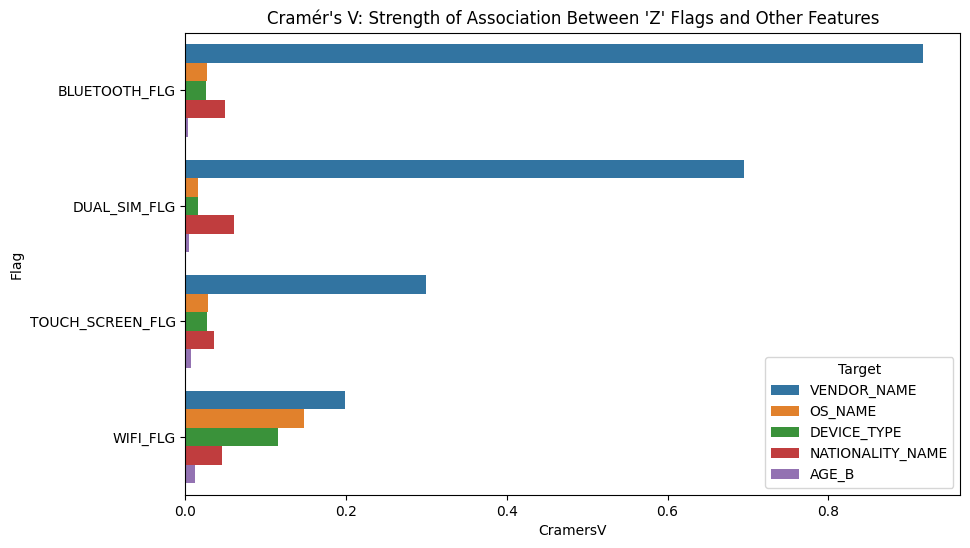

In [325]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='CramersV', y='Flag', hue='Target')
plt.title("Cramér's V: Strength of Association Between 'Z' Flags and Other Features")
plt.show()


In [326]:
flag_columns = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

vendors_with_z = {}

for col in flag_columns:
    vendors = df[df[col] == 'Z']['VENDOR_NAME'].dropna().unique().tolist()
    vendors_with_z[col] = vendors

# Display vendors for each flag
for flag, vendors in vendors_with_z.items():
    print(f"\nVendors with 'Z' in {flag} ({len(vendors)} vendors):")
    print(vendors)



Vendors with 'Z' in WIFI_FLG (9 vendors):
['bee', 'by2', 'cect', 'ck telecom', 'kenxinda', 'microsoft', 'noal technology', 'nokia', 'vell-com']

Vendors with 'Z' in BLUETOOTH_FLG (6 vendors):
['bee', 'by2', 'cect', 'ck telecom', 'eyang', 'vell-com']

Vendors with 'Z' in TOUCH_SCREEN_FLG (4 vendors):
['aolixin technology', 'by2', 'google', 'nokia']

Vendors with 'Z' in DUAL_SIM_FLG (5 vendors):
['bee', 'by2', 'ck telecom', 'kenxinda', 'vell-com']


In [327]:
flag_columns = ['WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

# Create a mask where any flag column has 'Z'
z_mask = df[flag_columns] == 'Z'

# Sum across the flag columns to count how many 'Z's per row
z_counts_per_row = z_mask.sum(axis=1)

# Add this count as a new column
df['Z_FLAG_COUNT'] = z_counts_per_row

# Group by vendor and sum how many rows have at least one 'Z'
z_counts_per_vendor = df[df['Z_FLAG_COUNT'] > 0].groupby('VENDOR_NAME')['Z_FLAG_COUNT'].count().sort_values(ascending=False)

# Display the result
print(z_counts_per_vendor)


VENDOR_NAME
nokia                 1644
microsoft              144
eyang                   41
ck telecom              12
vell-com                 7
aolixin technology       7
by2                      4
kenxinda                 4
google                   2
noal technology          2
cect                     1
bee                      1
Name: Z_FLAG_COUNT, dtype: int64


In [328]:
# Filter first 300 rows where any column has 'Z'
z_rows = df[df.isin(['Z']).any(axis=1)]

# Save to CSV
z_rows.to_csv('rows_with_Z.csv', index=False)


In [329]:
df[df['VENDOR_NAME'] == 'nokia'].OS_NAME.value_counts()

OS_NAME
proprietary    38949
other           4205
symbian          774
Name: count, dtype: int64

In [330]:
z_rows.MODEL_NAME.value_counts().to_dict().keys()

dict_keys(['3109 classic', '2323 classic', '7100 supernova', 'hd7', '6060', '6700 classic', '3500 classic', '7020', '2660', '6500 slide', '2710 navigation edition', '7310 supernova', '5000', 'c2-015', '7610 supernova', '7070 prism', '6131', '6555', '7700 king slider', '6085h', 'm1', 'm5', 'z30', 'x1', 'k100', 'x2-02', 'l50'])

By scraping GSMArena, we can extract features like Wi-Fi, Bluetooth, and Dual SIM. However, touchscreen info is often missing or unclear. An LLM is needed to infer touchscreen presence based on context (e.g., year, form factor).

In [331]:
z_rows = df[df.apply(lambda row: row.astype(str).str.contains('Z')).any(axis=1)]
print(f"Number of rows containing 'Z': {len(z_rows)}")

Number of rows containing 'Z': 4737


In [332]:
df.drop(columns=['Z_FLAG_COUNT'], inplace=True, errors='ignore')

Why?: Maybe I can fill Wi-Fi and Bluetootch, but Dual SIM will be fake

In [333]:
df = df[~df.apply(lambda row: row.astype(str).str.contains('Z')).any(axis=1)]

# Continue

In [334]:
# Ensure it's datetime (just in case)
df['CAL_DT'] = pd.to_datetime(df['CAL_DT'], errors='coerce')

# Sort by date
df_sorted1 = df.sort_values(by='CAL_DT')

# Display sorted DataFrame
df_sorted1.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
52609,2018-11-30,5 a5000,oneplus 5 a5000,oneplus,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Male,26-35,FRA,France,Non-Saudi,1,1.000000
22049,2018-11-30,s4,advan s4,advan,google,android,smartphone,Y,Y,N,Y,Y,Y,NaN,Female,26-35,PHL,Philippines,Non-Saudi,9,9.000000
179997,2018-11-30,c5-00,nokia c5-00,nokia,symbian ltd,symbian,smartphone,Y,Y,N,Y,Y,N,N,Male,NaN,SDN,Sudan,Non-Saudi,10,10.000000
22044,2018-11-30,magna dual,lg magna dual,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,NaN,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.000000
94823,2018-11-30,vibe shot,lenovo vibe shot,lenovo,google,android,smartphone,Y,NaN,Y,Y,Y,Y,NaN,Female,26-35,PHL,Philippines,Non-Saudi,31,4.833333


In [340]:
df_sorted1.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
52609,2018-11-30,5 a5000,oneplus 5 a5000,oneplus,google,android,smartphone,Y,Y,Y,Y,Y,Y,Y,Male,26-35,FRA,France,Non-Saudi,1,1.000000
22049,2018-11-30,s4,advan s4,advan,google,android,smartphone,Y,Y,N,Y,Y,Y,NaN,Female,26-35,PHL,Philippines,Non-Saudi,9,9.000000
179997,2018-11-30,c5-00,nokia c5-00,nokia,symbian ltd,symbian,smartphone,Y,Y,N,Y,Y,N,N,Male,NaN,SDN,Sudan,Non-Saudi,10,10.000000
22044,2018-11-30,magna dual,lg magna dual,lg,google,android,smartphone,Y,Y,N,Y,Y,Y,NaN,Female,36-55,ERI,Eritrea,Non-Saudi,1,1.000000
94823,2018-11-30,vibe shot,lenovo vibe shot,lenovo,google,android,smartphone,Y,NaN,Y,Y,Y,Y,NaN,Female,26-35,PHL,Philippines,Non-Saudi,31,4.833333


In [339]:
df.head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
0,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,NaN,IDN,Indonesia,Non-Saudi,1,1.0
1,2019-09-30,one touch 1010,alcatel one touch 1010,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,>55,LKA,Sri Lanka,Non-Saudi,1,1.0
2,2020-08-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,NaN,PHL,Philippines,Non-Saudi,1,1.0
3,2019-03-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,>55,SAU,Saudi Arabia,Saudi,3,3.0
4,2019-08-31,one touch 217,alcatel one touch 217,alcatel,alcatel,proprietary,mobile phone,Y,N,N,N,N,N,N,Female,26-35,SAU,Saudi Arabia,Saudi,9,9.0


In [341]:
df.isna().sum()

CAL_DT                    10353
MODEL_NAME                  430
BRAND_FULL_NAME            1024
BRAND_NAME                  872
VENDOR_NAME                 873
OS_NAME                       0
DEVICE_TYPE                   1
_2G_FLG                   10317
_3G_FLG                   10294
_4G_FLG                   10397
WIFI_FLG                  10398
BLUETOOTH_FLG             10334
TOUCH_SCREEN_FLG          10339
DUAL_SIM_FLG              10319
GENDER_TYPE_CD            30070
AGE_B                     35615
NATIONALITY_CD            11019
NATIONALITY_NAME          10989
SAUDI_NON_SAUDI           11019
DEVICE_COUNT              10318
DEVICE_COUNT_processed    10318
dtype: int64

In [342]:
df.to_csv('check.csv', index=False)


In [347]:
df.GENDER_TYPE_CD.value_counts()

GENDER_TYPE_CD
Male      97217
Female    45540
X           176
Name: count, dtype: int64

In [350]:
df[df['GENDER_TYPE_CD'] == 'X'].head()

,CAL_DT,MODEL_NAME,BRAND_FULL_NAME,BRAND_NAME,VENDOR_NAME,OS_NAME,DEVICE_TYPE,_2G_FLG,_3G_FLG,_4G_FLG,WIFI_FLG,BLUETOOTH_FLG,TOUCH_SCREEN_FLG,DUAL_SIM_FLG,GENDER_TYPE_CD,AGE_B,NATIONALITY_CD,NATIONALITY_NAME,SAUDI_NON_SAUDI,DEVICE_COUNT,DEVICE_COUNT_processed
666,2019-06-30,one touch 1050 dual sim,alcatel one touch 1050 dual sim,alcatel,alcatel,proprietary,mobile phone,y,n,n,n,n,n,y,X,>55,KWT,Kuw,Non-Saudi,2,2.0
2864,2020-10-31,1066 dual sim,alcatel 1066 dual sim,alcatel,alcatel,proprietary,mobile phone,y,NaN,n,n,n,n,y,X,18-25,KWT,Kuwait,Non-Saudi,1,1.0
4048,NaT,f18,archos f18,archos,archos,proprietary,mobile phone,NaN,n,n,n,y,n,y,X,36-55,GBR,United Kingdom,Non-Saudi,3,3.0
4113,2019-08-31,b312,beasy b312,beasy,beasy,proprietary,mobile phone,y,n,n,n,y,n,y,X,36-55,ETH,Ethiopia,Non-Saudi,1,1.0
4511,2020-02-29,z10,blackberry z10,blackberry,blackberry,blackberry os,smartphone,y,y,n,y,y,y,n,X,36-55,SYR,Syria,Non-Saudi,2,2.0


In [ ]:
df['GENDER_TYPE_CD'] = df['GENDER_TYPE_CD'].replace('X', np.nan)

In [345]:
flag_cols = [
    '_2G_FLG', '_3G_FLG', '_4G_FLG', 
    'WIFI_FLG', 'BLUETOOTH_FLG', 
    'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG'
]

# Convert to lowercase safely (only if value is string)
df[flag_cols] = df[flag_cols].applymap(
    lambda x: x.lower() if isinstance(x, str) else x
)

C:\Users\ma.aldawsari\AppData\Local\Temp\ipykernel_8096\2987273552.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[flag_cols] = df[flag_cols].applymap(


# Plan

1

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Columns to include
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']
support_cols = ['BRAND_FULL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']
all_cols = flag_cols + support_cols

# 2. Work on a copy
df_knn = df[all_cols].copy()

# 3. Encode categorical (support) columns
encoders = {}
for col in support_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le  # Save encoder for future inverse transform if needed

# 4. Encode flags (if not already binary)
for col in flag_cols:
    if df_knn[col].dtype != 'float' and df_knn[col].dtype != 'int':
        le = LabelEncoder()
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        encoders[col] = le

# 5. Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=all_cols)

# 6. Round flags (in case KNN gives float like 0.67, 1.0)
df_knn_imputed[flag_cols] = df_knn_imputed[flag_cols].round().astype(int)

# 7. Copy back imputed flag values to original dataframe
for col in flag_cols:
    df[col] = df[col].fillna(df_knn_imputed[col])

print("✅ Imputation complete. Missing values in flags are filled.")

In [ ]:
from sklearn.preprocessing import LabelEncoder

# 1. Columns to include
flag_cols = ['_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG', 'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']
support_cols = ['BRAND_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE']
all_cols = flag_cols + support_cols

# 2. Work on a copy
df_knn = df[all_cols].copy()

# 3. Encode categorical (support) columns
encoders = {}
for col in support_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le  # Save encoder for future inverse transform if needed

# 4. Encode flags (if not already binary)
for col in flag_cols:
    if df_knn[col].dtype != 'float' and df_knn[col].dtype != 'int':
        le = LabelEncoder()
        df_knn[col] = le.fit_transform(df_knn[col].astype(str))
        encoders[col] = le

# 5. Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=all_cols)

# 6. Round flags (in case KNN gives float like 0.67, 1.0)
df_knn_imputed[flag_cols] = df_knn_imputed[flag_cols].round().astype(int)

# 7. Copy back imputed flag values to original dataframe
for col in flag_cols:
    df[col] = df[col].fillna(df_knn_imputed[col])

print("✅ Imputation complete. Missing values in flags are filled.")

2

In [ ]:
# Rule 1: Fill BRAND_NAME using first word from BRAND_FULL_NAME
df['BRAND_NAME'] = df['BRAND_NAME'].fillna(
    df['BRAND_FULL_NAME'].str.split().str[0]
)

# Rule 2: KNN Imputer for remaining nulls
still_null_mask = df['BRAND_NAME'].isnull()

# Columns to use for KNN
knn_cols = ['BRAND_NAME', 'MODEL_NAME', 'VENDOR_NAME', 'OS_NAME', 'DEVICE_TYPE',
            '_2G_FLG', '_3G_FLG', '_4G_FLG', 'WIFI_FLG',
            'BLUETOOTH_FLG', 'TOUCH_SCREEN_FLG', 'DUAL_SIM_FLG']

df_knn = df[knn_cols].copy()

# Label encode all columns
encoders = {}
for col in knn_cols:
    le = LabelEncoder()
    df_knn[col] = le.fit_transform(df_knn[col].astype(str))
    encoders[col] = le

# Apply KNN Imputer
imputer = KNNImputer(n_neighbors=5)
df_knn_imputed = pd.DataFrame(imputer.fit_transform(df_knn), columns=knn_cols)

# Decode BRAND_NAME column
brand_col_encoded = df_knn_imputed['BRAND_NAME'].round().astype(int)
decoded_brands = encoders['BRAND_NAME'].inverse_transform(brand_col_encoded)

# Fill only where still null
df.loc[still_null_mask, 'BRAND_NAME'] = decoded_brands[still_null_mask]

print("✅ BRAND_NAME filled using first-word and KNN imputation.")


3